In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import rice
from platipy.imaging.registration.utils import apply_transform
from platipy.imaging import ImageVisualiser
from platipy.imaging.label.utils import get_com
from shrimpy.augmentation import random_augmentation_transform,  generate_random_vector_field_transform
from shrimpy.augmentation import random_rotation_transform, random_translation_transform, random_scale_transform
from shrimpy.augmentation import consistent_vector_field_transform
from shrimpy.pipeline import read_augment_write, read_augment_write_directory
from shrimpy.intensity import randomly_augment_image_intensity, apply_noise
from shrimpy.image_generation import visualise_image, compare_image_histograms, create_augmentation_visualisaitons
from shrimpy.image_generation import collate_augmentation_visualisations, create_image_visualisations
%matplotlib inline
import pandas as pd

In [2]:
import platipy
print(platipy.__version__)

0.2.1


In [3]:
results = pd.read_csv("results/results/results.csv")
results

,Unnamed: 0,i,Volume_GT [cc],Volume_GS [cc],Volume_TEST [cc],Volume_BASELINE [cc],CoM_Distance_GS [mm],CoM_Distance_TEST [mm],CoM_Distance_BASELINE [mm],DSC_GS,DSC_TEST,DSC_BASELINE,MASD_GS [mm],MASD_TEST [mm],MASD_BASELINE [mm],HD_GS [mm],HD_TEST [mm],HD_BASELINE [mm]
0,0,698094,0.759320,1.759883,1.115252,0.201694,19.062554,21.306808,21.696746,0.000000,0.000000,0.000000,15.761078,20.232215,23.508428,26.974230,88.250853,37.245342
1,1,724384,1.774507,3.683598,3.858058,5.074293,205.892896,200.369187,201.731067,0.000000,0.000000,0.000000,196.345925,188.308395,191.800677,211.125630,204.952062,205.759783
2,2,748583,3.256767,5.443764,6.145739,15.016326,3.245258,15.694386,21.379971,0.550909,0.350789,0.207120,1.871810,15.374922,10.666866,9.418978,105.227218,37.856004
3,3,771151,4.803269,4.590229,0.000000,0.000000,7.137989,NaN,NaN,0.290214,0.000000,0.000000,2.498013,NaN,NaN,13.612627,NaN,NaN
4,4,774840,45.687925,9.453970,10.197474,17.488163,9.180600,5.300946,4.258699,0.305458,0.247895,0.427682,9.453438,9.024257,5.395812,30.758959,29.654915,20.552466
5,5,775346,12.193277,5.784941,0.000000,0.000000,15.150606,NaN,NaN,0.346139,0.000000,0.000000,9.675453,NaN,NaN,45.803778,NaN,NaN
6,6,779739,8.249003,5.292346,14.688023,7.395171,176.207790,118.472870,177.648866,0.000000,0.001692,0.000000,162.517669,67.156140,162.451960,181.354362,173.215607,182.411375
7,7,783764,4.069486,0.676270,0.000000,0.000000,5.267609,NaN,NaN,0.214167,0.000000,0.000000,4.763795,NaN,NaN,17.476698,NaN,NaN
8,8,794128,5.400451,15.123116,5.008084,9.960557,6.118323,13.551661,9.240930,0.280897,0.156921,0.210914,2.371112,6.907120,3.363024,10.641315,22.424519,13.701426
9,9,799149,1.900777,5.527870,0.212674,2.650121,218.386860,76.129392,212.359950,0.000000,0.012579,0.000000,207.447008,17.945044,202.950246,219.649449,173.897165,212.686771


In [4]:
print(results.mean())

Unnamed: 0                         8.000000
i                             797248.000000
Volume_GT [cc]                     8.282542
Volume_GS [cc]                     8.746529
Volume_TEST [cc]                   4.519112
Volume_BASELINE [cc]               6.073677
CoM_Distance_GS [mm]              46.559290
CoM_Distance_TEST [mm]            64.138307
CoM_Distance_BASELINE [mm]        80.180462
DSC_GS                             0.278124
DSC_TEST                           0.133593
DSC_BASELINE                       0.125239
MASD_GS [mm]                      42.159497
MASD_TEST [mm]                    44.854937
MASD_BASELINE [mm]                74.624339
HD_GS [mm]                        57.369951
HD_TEST [mm]                      96.046127
HD_BASELINE [mm]                  89.565801
dtype: float64


In [5]:
print(sum(results['DSC_GS'] > 0))
print(sum(results['DSC_TEST'] > 0))
print(sum(results['DSC_BASELINE'] > 0))


12
9
7


In [6]:
gs_overlap = sum(results['DSC_GS'] > 0)
gs_miss = sum(results['Volume_GS [cc]'] > 0) - gs_overlap
print(gs_overlap, gs_miss)
test_overlap = sum(results['DSC_TEST'] > 0)
test_miss = sum(results['Volume_TEST [cc]'] > 0) - gs_overlap
print(test_overlap, test_miss)
baseline_overlap = sum(results['DSC_BASELINE'] > 0)
baseline_miss = sum(results['Volume_BASELINE [cc]'] > 0) - gs_overlap
print(baseline_overlap, baseline_miss)

12 5
9 1
7 1


C:\Users\arnal\AppData\Local\Temp/ipykernel_7980/1960024825.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


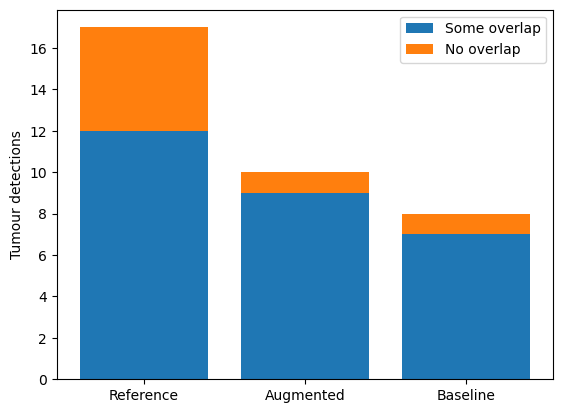

In [7]:
labels = ["Reference", "Augmented", "Baseline"]
overlap = [gs_overlap, test_overlap, baseline_overlap]
miss = [gs_miss, test_miss, baseline_miss]
fig, ax = plt.subplots()
ax.bar(labels, overlap, label="Some overlap")
ax.bar(labels, miss, bottom=overlap, label="No overlap")
# ax.plot([-0.5,2.5], [17,17])
ax.set_ylabel("Tumour detections")
ax.legend()
fig.savefig("results/tumour_detections.png", bbox_inches="tight")
fig.show()

In [8]:
results = results.dropna()
results

,Unnamed: 0,i,Volume_GT [cc],Volume_GS [cc],Volume_TEST [cc],Volume_BASELINE [cc],CoM_Distance_GS [mm],CoM_Distance_TEST [mm],CoM_Distance_BASELINE [mm],DSC_GS,DSC_TEST,DSC_BASELINE,MASD_GS [mm],MASD_TEST [mm],MASD_BASELINE [mm],HD_GS [mm],HD_TEST [mm],HD_BASELINE [mm]
0,0,698094,0.759320,1.759883,1.115252,0.201694,19.062554,21.306808,21.696746,0.000000,0.000000,0.000000,15.761078,20.232215,23.508428,26.974230,88.250853,37.245342
1,1,724384,1.774507,3.683598,3.858058,5.074293,205.892896,200.369187,201.731067,0.000000,0.000000,0.000000,196.345925,188.308395,191.800677,211.125630,204.952062,205.759783
2,2,748583,3.256767,5.443764,6.145739,15.016326,3.245258,15.694386,21.379971,0.550909,0.350789,0.207120,1.871810,15.374922,10.666866,9.418978,105.227218,37.856004
4,4,774840,45.687925,9.453970,10.197474,17.488163,9.180600,5.300946,4.258699,0.305458,0.247895,0.427682,9.453438,9.024257,5.395812,30.758959,29.654915,20.552466
6,6,779739,8.249003,5.292346,14.688023,7.395171,176.207790,118.472870,177.648866,0.000000,0.001692,0.000000,162.517669,67.156140,162.451960,181.354362,173.215607,182.411375
8,8,794128,5.400451,15.123116,5.008084,9.960557,6.118323,13.551661,9.240930,0.280897,0.156921,0.210914,2.371112,6.907120,3.363024,10.641315,22.424519,13.701426
9,9,799149,1.900777,5.527870,0.212674,2.650121,218.386860,76.129392,212.359950,0.000000,0.012579,0.000000,207.447008,17.945044,202.950246,219.649449,173.897165,212.686771
10,10,801641,0.983125,19.660209,0.358073,3.212917,19.557569,165.718448,165.144005,0.058504,0.000000,0.000000,16.086712,156.767610,149.521941,42.140271,170.162214,165.602638
12,12,845783,1.931915,4.850550,3.074849,3.683887,3.850010,3.867250,4.240416,0.446647,0.458926,0.452113,1.477614,1.103008,1.190851,6.381021,4.989813,6.381021
13,13,848003,1.210167,1.742087,0.788982,0.401412,2.539800,3.193855,2.718436,0.538513,0.427300,0.191411,1.442250,1.589738,2.523892,4.502037,5.727816,7.777625


In [9]:
fail = results.index[np.logical_or(results["DSC_GS"] == 0, results["DSC_TEST"] == 0)]
results = results.drop(index=fail)

In [10]:
print(results.index)

Int64Index([2, 4, 8, 12, 13, 14], dtype='int64')


In [11]:
results

,Unnamed: 0,i,Volume_GT [cc],Volume_GS [cc],Volume_TEST [cc],Volume_BASELINE [cc],CoM_Distance_GS [mm],CoM_Distance_TEST [mm],CoM_Distance_BASELINE [mm],DSC_GS,DSC_TEST,DSC_BASELINE,MASD_GS [mm],MASD_TEST [mm],MASD_BASELINE [mm],HD_GS [mm],HD_TEST [mm],HD_BASELINE [mm]
2,2,748583,3.256767,5.443764,6.145739,15.016326,3.245258,15.694386,21.379971,0.550909,0.350789,0.207120,1.871810,15.374922,10.666866,9.418978,105.227218,37.856004
4,4,774840,45.687925,9.453970,10.197474,17.488163,9.180600,5.300946,4.258699,0.305458,0.247895,0.427682,9.453438,9.024257,5.395812,30.758959,29.654915,20.552466
8,8,794128,5.400451,15.123116,5.008084,9.960557,6.118323,13.551661,9.240930,0.280897,0.156921,0.210914,2.371112,6.907120,3.363024,10.641315,22.424519,13.701426
12,12,845783,1.931915,4.850550,3.074849,3.683887,3.850010,3.867250,4.240416,0.446647,0.458926,0.452113,1.477614,1.103008,1.190851,6.381021,4.989813,6.381021
13,13,848003,1.210167,1.742087,0.788982,0.401412,2.539800,3.193855,2.718436,0.538513,0.427300,0.191411,1.442250,1.589738,2.523892,4.502037,5.727816,7.777625
14,14,860243,22.348500,41.869328,30.958071,36.761721,3.681603,3.480708,1.265715,0.534980,0.614066,0.590908,2.942239,3.110997,2.827306,22.013772,37.806895,27.860330


In [12]:
print(results.mean())
print(results.std())

Unnamed: 0                         8.833333
i                             811930.000000
Volume_GT [cc]                    13.305954
Volume_GS [cc]                    13.080469
Volume_TEST [cc]                   9.362200
Volume_BASELINE [cc]              13.885344
CoM_Distance_GS [mm]               4.769265
CoM_Distance_TEST [mm]             7.514801
CoM_Distance_BASELINE [mm]         7.184028
DSC_GS                             0.442901
DSC_TEST                           0.375983
DSC_BASELINE                       0.346691
MASD_GS [mm]                       3.259744
MASD_TEST [mm]                     6.185007
MASD_BASELINE [mm]                 4.327959
HD_GS [mm]                        13.952680
HD_TEST [mm]                      34.305196
HD_BASELINE [mm]                  19.021479
dtype: float64
Unnamed: 0                        4.996666
i                             45797.062395
Volume_GT [cc]                   17.717334
Volume_GS [cc]                   14.837331
Volume_TEST [cc]     

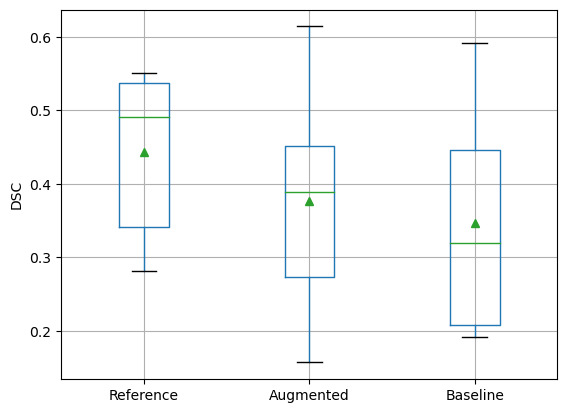

In [13]:
results.boxplot(["DSC_GS", "DSC_TEST", "DSC_BASELINE"], showmeans=True)
plt.xticks(plt.xticks()[0], ["Reference", "Augmented", "Baseline"])
plt.ylabel("DSC")
plt.savefig("results/DSC_boxplot.png", bbox_inches="tight")
plt.show()

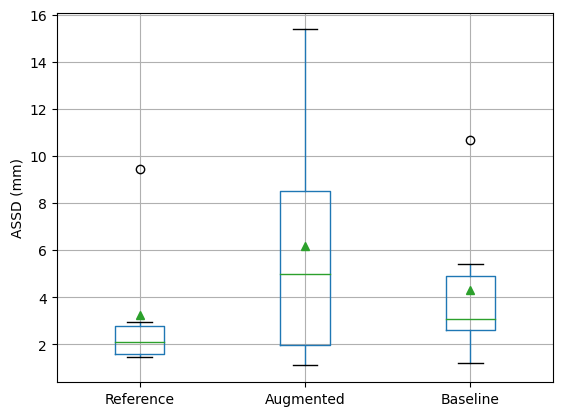

In [14]:
results.boxplot(["MASD_GS [mm]", "MASD_TEST [mm]", "MASD_BASELINE [mm]"], showmeans=True, whis=1.5)
plt.xticks(plt.xticks()[0], ["Reference", "Augmented", "Baseline"])
plt.ylabel("ASSD (mm)")
plt.savefig("results/ASSD_boxplot.png", bbox_inches="tight")
plt.show()

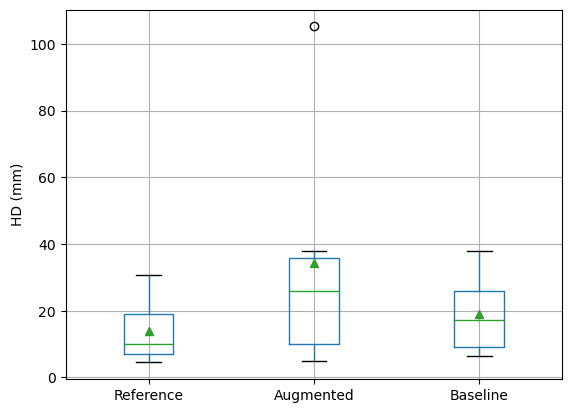

In [15]:
results.boxplot(["HD_GS [mm]", "HD_TEST [mm]", "HD_BASELINE [mm]"], showmeans=True, whis=1.5)
plt.xticks(plt.xticks()[0], ["Reference", "Augmented", "Baseline"])
plt.ylabel("HD (mm)")
plt.savefig("results/HD_boxplot.png", bbox_inches="tight")
plt.show()

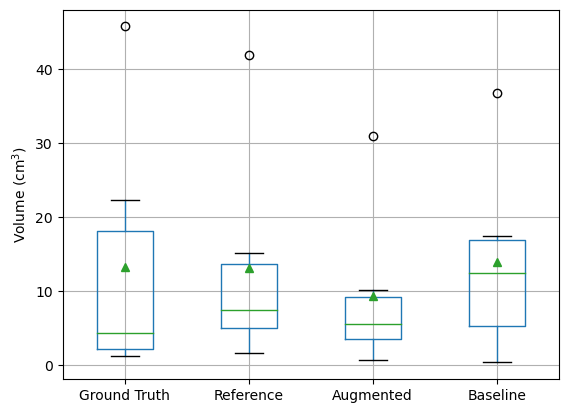

In [16]:
results.boxplot(["Volume_GT [cc]", "Volume_GS [cc]", "Volume_TEST [cc]", "Volume_BASELINE [cc]"], showmeans=True, whis=1.5)
plt.xticks(plt.xticks()[0], ["Ground Truth", "Reference", "Augmented", "Baseline"])
plt.ylabel(r"Volume (cm$^3$)")
plt.savefig("results/volume_boxplot.png", bbox_inches="tight")
plt.show()

In [17]:
results["Volume_ratio_GS"] = results["Volume_GS [cc]"]/results["Volume_GT [cc]"]
results["Volume_ratio_TEST"] = results["Volume_TEST [cc]"]/results["Volume_GT [cc]"]
results["Volume_ratio_BASELINE"] = results["Volume_BASELINE [cc]"]/results["Volume_GT [cc]"]

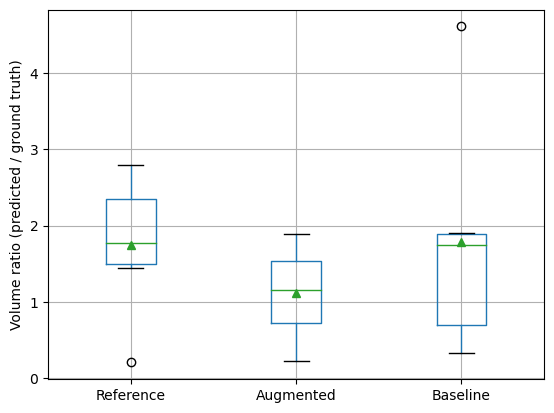

In [18]:
results.boxplot(["Volume_ratio_GS", "Volume_ratio_TEST", "Volume_ratio_BASELINE"], showmeans=True, whis=1.5, showfliers=True)
plt.xticks(plt.xticks()[0], ["Reference", "Augmented", "Baseline"])
plt.ylabel(r"Volume ratio (predicted / ground truth)")
plt.savefig("results/volume_ratio_boxplot.png", bbox_inches="tight")
plt.show()

[347, 395, 357, 399]


C:\Users\arnal\anaconda3\lib\site-packages\platipy\imaging\visualisation\visualiser.py:1016: UserWarning: The following kwargs were not used by contour: 'label'
  temp = ax.contour(


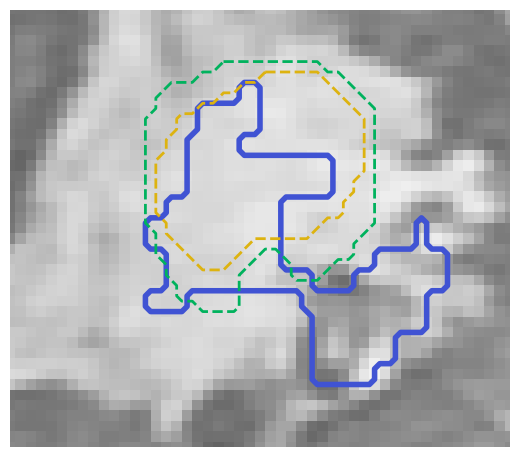

In [19]:
# Slightly misaligned, fairly accurate
# patient = "860243"
patient = "748583"
patient_T1 = sitk.ReadImage(f"../honours/ISPY2_FIRST126/CONVERTED_PROCESSED/ACRIN-6698-{patient}/IMG_T1.nii.gz", sitk.sitkFloat64)
patient_GT = sitk.ReadImage(f"../honours/ISPY2_FIRST126/CONVERTED_PROCESSED/ACRIN-6698-{patient}/MASK_TUMOUR.nii.gz", sitk.sitkUInt8)
patient_reference = sitk.ReadImage(f"results/results/output/GOLDSTANDARD/ISPY_{patient}.nii.gz")
patient_limited = sitk.ReadImage(f"results/results/output/UNAUGMENTED/ISPY_{patient}.nii.gz")
patient_augmented = sitk.ReadImage(f"results/results/output/AUGMENTED/ISPY_{patient}.nii.gz")
GT_com = get_com(patient_GT)
reference_com = get_com(patient_reference)
augmented_com = get_com(patient_augmented)

vis = ImageVisualiser(patient_T1, cut=augmented_com[0], axis='z', figure_size_in=5)
vis.add_contour(patient_GT, name="Ground Truth", color="red", show_legend=False, linewidth=1)
# fig = vis.show()

vis = ImageVisualiser(patient_T1, cut=augmented_com[0], axis='z', figure_size_in=5)
vis.add_contour(patient_GT, name="Ground Truth", color="#4053d3", show_legend=False, linewidth=4)
# vis.add_contour(patient_reference, name="Reference Prediction", color="#b51d14", show_legend=False, linestyle='--')
vis.add_contour(patient_augmented, name="Augmented Prediction", color="#ddb310", show_legend=False, linestyle='--')
vis.add_contour(patient_limited, name="Limited Prediction", color="#00b25d", show_legend=False, linestyle='--')


vis.set_limits_from_label(patient_GT or patient_reference or patient_augmented or patient_limited, expansion=5)
fig = vis.show()
print(vis._ImageVisualiser__limits)
# fig.savefig("results/legendless_good_example_prediction")

[91, 194, 208, 291]


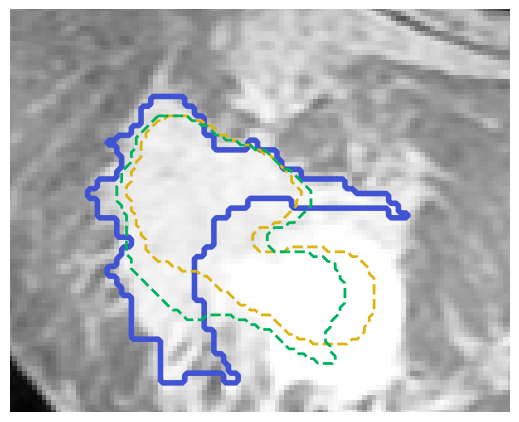

In [20]:
# imperceptibly misaligned, some inaccuracy
patient = "774840"
patient_T1 = sitk.ReadImage(f"../honours/ISPY2_FIRST126/CONVERTED_PROCESSED/ACRIN-6698-{patient}/IMG_T1.nii.gz", sitk.sitkFloat64)
patient_GT = sitk.ReadImage(f"../honours/ISPY2_FIRST126/CONVERTED_PROCESSED/ACRIN-6698-{patient}/MASK_TUMOUR.nii.gz", sitk.sitkUInt8)
patient_reference = sitk.ReadImage(f"results/results/output/GOLDSTANDARD/ISPY_{patient}.nii.gz")
patient_limited = sitk.ReadImage(f"results/results/output/UNAUGMENTED/ISPY_{patient}.nii.gz")
patient_augmented = sitk.ReadImage(f"results/results/output/AUGMENTED/ISPY_{patient}.nii.gz")
GT_com = get_com(patient_GT)
reference_com = get_com(patient_reference)
augmented_com = get_com(patient_augmented)

vis = ImageVisualiser(patient_T1, cut=augmented_com[0], axis='z', figure_size_in=5)
vis.add_contour(patient_GT, name="Ground Truth", color="red", show_legend=False, linewidth=1)
# fig = vis.show()

vis = ImageVisualiser(patient_T1, cut=augmented_com[0], axis='z', figure_size_in=5)
vis.add_contour(patient_GT, name="Ground Truth", color="#4053d3", show_legend=False, linewidth=4)
# vis.add_contour(patient_reference, name="Reference Prediction", color="#b51d14", show_legend=False, linestyle='--')
vis.add_contour(patient_augmented, name="Augmented Prediction", color="#ddb310", show_legend=False, linestyle='--')
vis.add_contour(patient_limited, name="Limited Prediction", color="#00b25d", show_legend=False, linestyle='--')


vis.set_limits_from_label(patient_GT or patient_reference or patient_augmented or patient_limited, expansion=5)
fig = vis.show()
print(vis._ImageVisualiser__limits)
# fig.savefig("results/legendless_bad_example_prediction")

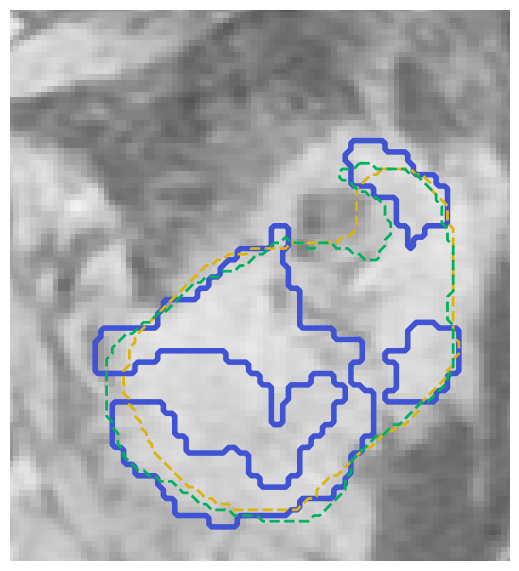

In [21]:
# looks aligned, interesting differences
patient = "860243"
patient_T1 = sitk.ReadImage(f"../honours/ISPY2_FIRST126/CONVERTED_PROCESSED/ACRIN-6698-{patient}/IMG_T1.nii.gz", sitk.sitkFloat64)
patient_GT = sitk.ReadImage(f"../honours/ISPY2_FIRST126/CONVERTED_PROCESSED/ACRIN-6698-{patient}/MASK_TUMOUR.nii.gz", sitk.sitkUInt8)
patient_reference = sitk.ReadImage(f"results/results/output/GOLDSTANDARD/ISPY_{patient}.nii.gz")
patient_limited = sitk.ReadImage(f"results/results/output/UNAUGMENTED/ISPY_{patient}.nii.gz")
patient_augmented = sitk.ReadImage(f"results/results/output/AUGMENTED/ISPY_{patient}.nii.gz")
GT_com = get_com(patient_GT)
reference_com = get_com(patient_reference)
augmented_com = get_com(patient_augmented)

vis = ImageVisualiser(patient_T1, cut=augmented_com[0], axis='z', figure_size_in=5)
vis.add_contour(patient_GT, name="Ground Truth", color="red", show_legend=False, linewidth=1)
# fig = vis.show()

vis = ImageVisualiser(patient_T1, cut=augmented_com[0], axis='z', figure_size_in=5)
vis.add_contour(patient_GT, name="Ground Truth", color="#4053d3", show_legend=False, linewidth=4)
# vis.add_contour(patient_reference, name="Reference Prediction", color="#b51d14", show_legend=False, linestyle='--')
vis.add_contour(patient_augmented, name="Augmented Prediction", color="#ddb310", show_legend=False, linestyle='--')
vis.add_contour(patient_limited, name="Limited Prediction", color="#00b25d", show_legend=False, linestyle='--')


vis.set_limits_from_label(patient_GT or patient_reference or patient_augmented or patient_limited, expansion=5)
fig = vis.show()